In [1]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load the datasets
movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')

In [3]:
# Display the first few rows of each dataframe
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## 1. How many movies has a user with id 2 watched?

In [5]:
# Filtering data for user 2
user_2_ratings = ratings_df[ratings_df['userId'] == 2]

# Count how many movies user 2 has watched
num_movies_watched_by_user_2 = user_2_ratings.shape[0]

# Plotting the distribution of their ratings
rating_counts = user_2_ratings['rating'].value_counts().sort_index()

## 2. Plot a bar chart of their movie ratings

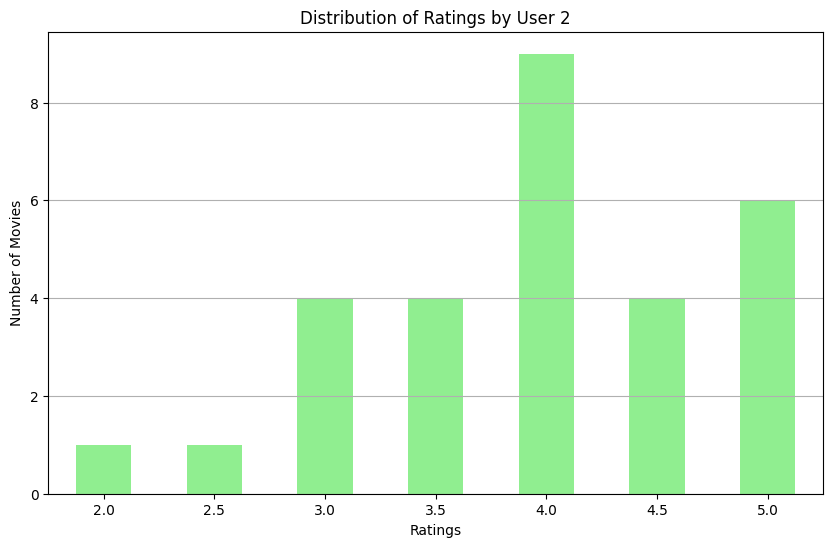

In [6]:
# Plotting the bar chart
plt.figure(figsize=(10, 6))
rating_counts.plot(kind='bar', color='lightgreen')
plt.title('Distribution of Ratings by User 2')
plt.xlabel('Ratings')
plt.ylabel('Number of Movies')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [7]:
print("Number of movies viewed by user 2:", num_movies_watched_by_user_2)

Number of movies viewed by user 2: 29


In [8]:
rating_counts_df = rating_counts.reset_index()
rating_counts_df.columns = ['rating', 'count']

print("Number of movies viewed by user 2 and their rating:")
rating_counts_df

Number of movies viewed by user 2 and their rating:


,rating,count
0,2.0,1
1,2.5,1
2,3.0,4
3,3.5,4
4,4.0,9
5,4.5,4
6,5.0,6


## 3. What are some of user 2's top movies?

In [9]:
# Get highly-rated movies by User 2
top_rated_movies_user_2 = user_2_ratings[user_2_ratings['rating'] >= 4.5]

# Get movie titles
top_rated_movies_user_2 = top_rated_movies_user_2.merge(movies_df, on='movieId', how='left')

# Arrange and show data
top_rated_movies_user_2 = top_rated_movies_user_2[['movieId', 'title', 'rating']]
top_rated_movies_user_2.sort_values(by='rating', ascending=False)

,movieId,title,rating
2,60756,Step Brothers (2008),5.0
5,80906,Inside Job (2010),5.0
6,89774,Warrior (2011),5.0
7,106782,"Wolf of Wall Street, The (2013)",5.0
8,122882,Mad Max: Fury Road (2015),5.0
9,131724,The Jinx: The Life and Deaths of Robert Durst ...,5.0
0,1704,Good Will Hunting (1997),4.5
1,58559,"Dark Knight, The (2008)",4.5
3,68157,Inglourious Basterds (2009),4.5
4,80489,"Town, The (2010)",4.5


## 4. Find the most similar user in the movielens dataset to user 2 using at least 2 distance metrics.

In [10]:
# Import the necessary libraries
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, cityblock

In [11]:
# Fill missing values with 0 for unrated movies
user_item_matrix = ratings_df.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)

# Extract user 2's ratings
user_2_vector = user_item_matrix.loc[2].values

# Compute the metrics 
compute_metrics = lambda user_vector, matrix: pd.DataFrame({
    'userId': matrix.index,
    'cosine_similarity': cosine_similarity([user_vector], matrix).flatten(),
    'euclidean_distance': [euclidean(user_vector, matrix.loc[user].values) for user in matrix.index],
    'cityblock_distance': [cityblock(user_vector, matrix.loc[user].values) for user in matrix.index]
})

# Compute the metrics
similarity_df = compute_metrics(user_2_vector, user_item_matrix)

# Find the most similar users excluding user 2
most_similar_user_cosine = similarity_df[similarity_df['userId'] != 2].nlargest(1, 'cosine_similarity')[['userId', 'cosine_similarity']]
most_similar_user_euclidean = similarity_df[similarity_df['userId'] != 2].nsmallest(1, 'euclidean_distance')[['userId', 'euclidean_distance']]
most_similar_user_cityblock = similarity_df[similarity_df['userId'] != 2].nsmallest(1, 'cityblock_distance')[['userId', 'cityblock_distance']]

In [12]:
print("Most Similar User to User 2 (Cosine Similarity):")
most_similar_user_cosine

Most Similar User to User 2 (Cosine Similarity):


,userId,cosine_similarity
365,366,0.300074


In [13]:
print("Most Similar User to User 2 (Euclidean Distance):")
most_similar_user_euclidean

Most Similar User to User 2 (Euclidean Distance):


,userId,euclidean_distance
441,442,22.627417


In [14]:
print("Most Similar User to User 2 (Cityblock Distance):")
most_similar_user_cityblock

Most Similar User to User 2 (Cityblock Distance):


,userId,cityblock_distance
441,442,140.0


## 5. Recommend a few movies for user 2 using similarity metrics.

In [15]:
# Function that recommends movies to a user based on another similar user.
def recommend_movies(similar_user_id, user_ratings, all_ratings, movies_data, num_recommendations=5):
    # Get top-rated movies by the similar user
    similar_user_top_movies = all_ratings[(all_ratings['userId'] == similar_user_id) & (all_ratings['rating'] >= 4.5)]
    
    # Exclude movies already rated by the user
    recommendations = similar_user_top_movies[~similar_user_top_movies['movieId'].isin(user_ratings['movieId'])]
    
    # Merge with the movies data to get titles
    recommendations = recommendations.merge(movies_data, on='movieId', how='left')
    
    # Return top N recommendations
    return recommendations[['movieId', 'title', 'rating']].head(num_recommendations)

# Get recommendations for user 2 from their most similar user (User 366)
user_2_recommendations = recommend_movies(366, user_2_ratings, ratings_df, movies_df)

In [16]:
print("Recommended movies for the user 2:")
user_2_recommendations

Recommended movies for the user 2:


,movieId,title,rating
0,1089,Reservoir Dogs (1992),5.0
1,2959,Fight Club (1999),4.5
2,4993,"Lord of the Rings: The Fellowship of the Ring,...",4.5
3,7153,"Lord of the Rings: The Return of the King, The...",4.5
4,8368,Harry Potter and the Prisoner of Azkaban (2004),4.5


# Analysis and Summary

## Movie Watching Habits and Preferences of User 2

User 2 saw a total of 29 movies, with a predilection for films rated 3.0 to 5.0, with the majority rated 4.0. Their top-rated films are from a variety of genres, including drama, action, and documentaries, reflecting a wide range of interests.

## Similarity Metrics and Recommendations

**Cosine Similarity:** Selected for its efficacy in high-dimensional spaces and its emphasis on the angle between rating vectors rather than their magnitudes. It found that User 366 was most similar to User 2.

**Euclidean and City Block Distances:** These distances measure direct line and block-by-block distances in rating space, respectively. Both identified User 442 as the closest to User 2, although they typically work best in lower-dimensional spaces.

## Recommendations for User 2

A number of films, including well-known series like "Harry Potter" and "Lord of the Rings," as well as critically acclaimed pictures like "Reservoir Dogs," were suggested based on User 366's choices. These suggestions are in line with User 2's evident preferences for a wide range of genres and well regarded movies.

## Conclusion

The combination of cosine similarity (angle-based) and Euclidean/City Block distances (magnitude-based) gives a full picture of user similarities. These metrics-derived recommendations are fair, and they are consistent with User 2's previously defined preferences. This method implies that individuals with similar likes would evaluate movies similarly, which is a basic concept of collaborative filtering in recommender systems.

For both parts of the assignment, write a short analysis and summary of what you did, the results, and the significance. Do this in a markdown cell here at the bottom, like this one.